# Importing all the necessary packages 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms,models,datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Read the training dataset which is in csv format using pandas

In [7]:
df = pd.read_csv('/content/training.csv')
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [8]:
# check if any null values are present in the dataset
df.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

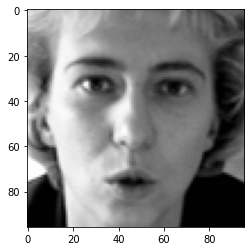

In [9]:
# Use the 'fillna' to fill the null values using ffill method

df.fillna(method='ffill', inplace=True)

# separate the image data from the dataset
img_dt = []

for i in range(len(df)):
  img_dt.append(df['Image'][i].split(' '))
  
X = np.array(img_dt, dtype='float')

# Visualizing one of the images:
plt.imshow(X[1].reshape(96,96), cmap='gray')

In [10]:
# check again to see if there are any null values present
df.isnull().sum().sum()

0

In [11]:
# drop the image data from the dataset 

facial_pts_data = df.drop(['Image'], axis=1)
facial_pts = []

for i in range(len(facial_pts_data)):
  facial_pts.append(facial_pts_data.iloc[i])
  
y = np.array(facial_pts, dtype='float')

# Create Dataloaders to train the dataset using PyTorch

In [12]:
dataset_size = len(X)
indices = list(range(dataset_size))
val_num = int(np.floor(0.2 * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[val_num:], indices[:val_num]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# converting numpy data to torch data
loader_object = data_utils.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())

# creating train and valid dataloaders 
train_loader = data_utils.DataLoader(loader_object, batch_size=32, sampler=train_sampler)
valid_loader = data_utils.DataLoader(loader_object, batch_size=32, sampler=valid_sampler)

In [13]:
# create a CNN classifier to train the data

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5) # (b,1,96,96) to (b,4,92,92)
        self.conv1_bn = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3) # (b,4,46,46) to (b,64,44,44)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # (b,64,22,22) to (b,128,20,20)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3) # (b,128,10,10) to (b,256,8,8)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 30)
        self.dp1 = nn.Dropout(p=0.4)
    
    def forward(self, x, verbose=False):
        # apply conv1, relu and maxpool2d
        x = self.conv1_bn(self.conv1(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # apply conv2, relu and maxpool2d
        x = self.conv2_bn(self.conv2(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # apply conv3, relu and maxpool2d
        x = self.conv3_bn(self.conv3(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dp1(x)
        
        # apply conv4, relu and maxpool2d
        x = self.conv4_bn(self.conv4(x))
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # apply dropout
        x = self.dp1(x)
        
        x = x.view(-1, 256*4*4)
        
        # now use FC layer with relu
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc3(x)
        return x    

model = CNN()

In [14]:
# Load the model to gpu for training
model = model.to('cuda')

In [15]:
criteria = nn.MSELoss()
optimizer=optim.Adam(model.parameters())

# a scheduler to reduce the optimizer value by a factor, if valid loss is not decreasing
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.369, patience = 5, verbose = True)

In [16]:
# training for 30 epochs
epochs = 30
valid_loss_min = np.Inf
train_losses=[]
valid_losses=[]


for e in range(epochs):
    trainloss=0
    validloss=0
    
    
    model.train()
    for images,labels in train_loader:
        images,labels=images.to('cuda'),labels.to('cuda')
        optimizer.zero_grad()   
        images = images.view(-1, 96*96)
        images = images.view(-1, 1, 96, 96)
        out=model(images)
        loss=criteria(out,labels)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
  
    with torch.no_grad():
      model.eval()
      num_correct=0
      num_examples=0
      for images,labels in valid_loader:
          images,labels=images.to('cuda'),labels.to('cuda')
          images = images.view(-1, 96*96)
          images = images.view(-1, 1, 96, 96)
          out=model(images)
          loss=criteria(out,labels)
          validloss+=loss.item()

          
      train_loss = trainloss/len(train_loader.sampler)
      train_losses.append(train_loss)

      valid_loss = validloss/len(valid_loader.sampler)
      valid_losses.append(valid_loss)

      scheduler.step(valid_loss)
    
      print(e+1)
      print('trainloss = '+str(train_loss)+'  validloss = '+str(valid_loss))

    
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss   

1
trainloss = 5.025099728631635  validloss = 6.994541230482612
Validation loss decreased (inf --> 6.994541).  Saving model ...
2
trainloss = 1.954239801988534  validloss = 5.376587303925102
Validation loss decreased (6.994541 --> 5.376587).  Saving model ...
3
trainloss = 1.6410435602174582  validloss = 5.67385178749404
4
trainloss = 1.792948772890348  validloss = 0.5230099994126071
Validation loss decreased (5.376587 --> 0.523010).  Saving model ...
5
trainloss = 1.6212950801173  validloss = 5.1690236748830065
6
trainloss = 1.5215678539681943  validloss = 4.154881192404298
7
trainloss = 1.4071730001598386  validloss = 2.1805224706299176
8
trainloss = 1.5405483475813628  validloss = 4.361756719368582
9
trainloss = 1.3863522864402609  validloss = 3.652700295593825
Epoch    10: reducing learning rate of group 0 to 3.6900e-04.
10
trainloss = 1.2981054647594479  validloss = 4.888758792701218
11
trainloss = 1.1942822669414763  validloss = 3.658070929089364
12
trainloss = 1.1794959403098897 

In [17]:
# loading the saved model 
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

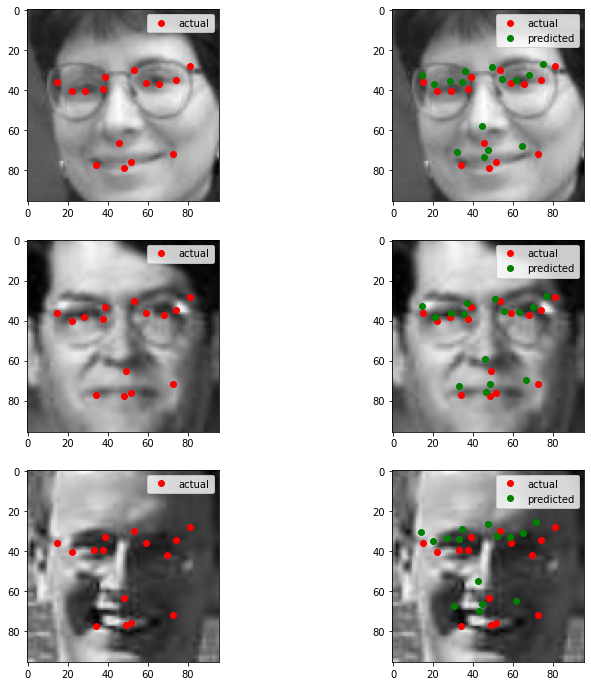

In [18]:
# plot the images to check acutal vs predicted 
def plot_samples(X, y, model, num_samples):
  
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12,12))
    
    for row in range(num_samples):
      sample_idx = np.random.choice(len(X))
      x = X[sample_idx]
      x = torch.from_numpy(x).float().view(1,1,96,96).to('cuda')
      actual_y = y[sample_idx]
      pred_y = model(x)
      img = X[sample_idx].reshape(96,96)
      
      actual_y = np.vstack(np.split(actual_y, 15)).T
      pred_y = pred_y.cpu().data.numpy()[0]
      pred_y = np.vstack(np.split(pred_y, 15)).T
      
      axes[row, 0].imshow(img, cmap='gray')
      axes[row, 0].plot(actual_y[0], actual_y[1], 'o', color='red', label='actual')
      axes[row, 0].legend()
      axes[row, 1].imshow(img, cmap='gray')
      axes[row, 1].plot(actual_y[0], actual_y[1], 'o', color='red', label='actual')
      axes[row, 1].plot(pred_y[0], pred_y[1], 'o', color='green', label='predicted')
      axes[row, 1].legend()

plot_samples(X, y, model, 3)      

In [19]:
# loading the test data
test_data = pd.read_csv('test.csv')

img_dt = []

for i in range(len(test_data)):
  img_dt.append(test_data['Image'][i].split(' '))
  
test_X = np.array(img_dt, dtype='float')

# converting to torch tensor and feeding to the model 
test_X_torch = torch.from_numpy(test_X).float().view(len(test_X),1,96,96).to('cuda')
test_predictions = model(test_X_torch)
test_predictions = test_predictions.cpu().data.numpy()

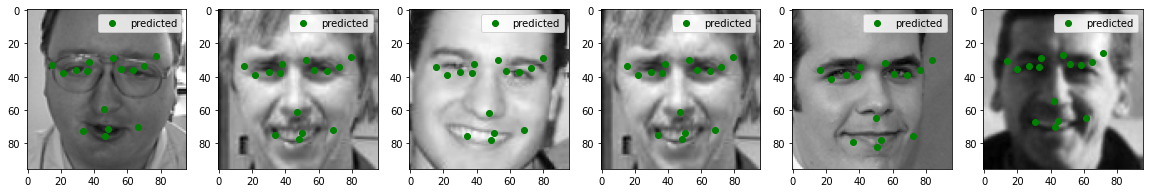

In [20]:
# ploting to check how well the model is performing on test data
def plot_samples_test(X, y, num_samples):
  fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,12))
  
  for row in range(num_samples):
    sample_idx = np.random.choice(len(X))
    img = X[sample_idx].reshape(96,96)
    predicted = y[sample_idx]
    
    predicted = np.vstack(np.split(predicted, 15)).T

    axes[row].imshow(img, cmap='gray')
    axes[row].plot(predicted[0], predicted[1], 'o', color='green', label='predicted')
    axes[row].legend()
  
plot_samples_test(test_X, test_predictions, 6)